In [1]:
import os #
import shutil # 
import cv2
import xml.etree.ElementTree as ET #
import matplotlib.pyplot as plt #
import matplotlib.patches as patches
import numpy as np
from sklearn.model_selection import train_test_split 

# Data

In [2]:
DATASET_DIR = 'datasets/'
ANNOTATIONS_DIR = 'datasets/annotations/'
IMAGES_DIR = 'datasets/images/'
LABELS_DIR = 'datasets/labels/'

CLASS_INDEXS = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
CLASS_NAMES = {0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'}

In [3]:
def xml_bnbox_to_yolo_bndbox(bndbox, width, height):
    """Convert xml bounding box to YOLO bounding box.
    
        Args:
            bndbox (list | np.darray): A xml bounding box with format [xmin, ymin, xmax, ymax]
            width (int): A width of entire image
            height (int): A height of entire image
        Returns:
            yolo_bndbox (list): The bounding box in YOLO format [x_center, y_center, bnd_width, bndbox_height]
    """
    x_center = ((bndbox[0] + bndbox[2]) / 2.) / width
    y_center = ((bndbox[1] + bndbox[3]) / 2.) / height
    bnd_width = (bndbox[2] - bndbox[0]) / width
    bnd_height = (bndbox[3] - bndbox[1]) / height
    yolo_bndbox = [x_center, y_center, bnd_width, bnd_height]
    return yolo_bndbox

def yolo_bndbox_to_xml_bndbox(bndbox, width, height):
    """Convert YOLO bounding box to xml bounding box.
    
        Args:
            bndbox (list | np.darray): A YOLO bounding box with format [x_center, y_center, bnd_width, bndbox_height]
            width (int): A width of entire image
            height (int): A height of entire image
        Returns:
            xml_bndbox (list): The bounding box in xml format [xmin, ymin, xmax, ymax]
    """
    xmin = (bndbox[0] - bndbox[2] / 2.) * width
    ymin = (bndbox[1] - bndbox[3] / 2.) * height
    xmax = (bndbox[0] + bndbox[2] / 2.) * width
    ymax = (bndbox[1] + bndbox[3] / 2.) * height
    xml_bndbox = [int(xmin), int(ymin), int(xmax), int(ymax)]
    return xml_bndbox

In [4]:
def convert_xml_to_yolo_format(filepath):
    """Convert all objects in xml file to Ultralytics YOLO format.
    
        Args:
            filepath (Path): Path to xml file 
        Returns:
            all_objects (list): All objects in Ultralytics YOLO format
    """
    tree = ET.parse(filepath)
    root = tree.getroot()
    image_width = int(root.find('size').find('width').text)    
    image_height = int(root.find('size').find('height').text)
    
    all_objects = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_index = CLASS_INDEXS[class_name]
        xml_bndbox = [int(obj.find('bndbox')[i].text) for i in range(4)]
        yolo_bndbox = xml_bnbox_to_yolo_bndbox(xml_bndbox, image_width, image_height)
        all_objects.append([class_index] + yolo_bndbox)
    return all_objects

# Preprocess the dataset 
Skip this one if you have already preprocessed the dataset (continue from  **Visuallization**).

In [5]:
if os.path.exists(LABELS_DIR):
    assert any([x not in os.listdir(LABELS_DIR) for x in ['train', 'val', 'test']]), "Looks like the dataset was preprocessed"

In [6]:
# Write to txt file
os.makedirs('datasets/labels', exist_ok=True)
for filename in os.listdir(ANNOTATIONS_DIR):
    filepath = os.path.join(ANNOTATIONS_DIR, filename)
    data = convert_xml_to_yolo_format(filepath)
    f = open(f'datasets/labels/{filename[:-4]}.txt','w')            
    f.write('\n'.join(' '.join(map(str, obj)) for obj in data))
    f.close()   

In [7]:
def move_file(filenames, img_path, img_dest, label_path, label_dest):
    os.makedirs(img_dest, exist_ok=True)    
    os.makedirs(label_dest, exist_ok=True)

    for filename in filenames:
        img_src = os.path.join(img_path, filename + '.png')
        label_src = os.path.join(label_path, filename + '.txt')
        shutil.move(img_src, img_dest)
        shutil.move(label_src, label_dest)

In [8]:
all_filenames = [f[:-4] for f in os.listdir(IMAGES_DIR)]

#  Split train-val-test 
random_state = 1
train, val_test = train_test_split(all_filenames, test_size=0.3, random_state=random_state, shuffle=True) 
val, test = train_test_split(list(val_test), test_size=0.5, random_state=random_state, shuffle=True)

# Copy to corresponding folder
move_file(train, IMAGES_DIR, f'{IMAGES_DIR}/train/', LABELS_DIR, f'{LABELS_DIR}/train/')
move_file(val, IMAGES_DIR, f'{IMAGES_DIR}/val/', LABELS_DIR, f'{LABELS_DIR}/val/')
move_file(test, IMAGES_DIR, f'{IMAGES_DIR}/test/', LABELS_DIR, f'{LABELS_DIR}/test/')

# Visualization

In [9]:
def draw_bounding_boxes(image, bndboxes, with_confidence_score=False, is_rgb=True):
    """Draw parsing bounding boxes on an parsing image.
        Args:
            image (Image): The original image.
            bndboxes (list): List of predicted bounding boxes, format: [x, y, w, h, cls, conf].
            name (str): Name to save the image.
            save_dir (path, optional): Directory to save the image. Defaults to "saved_images".
            with_confident_score (bool, optional): Show confidence score or not. Defaults is False.
            is_rgb (bool, optional): The parsing image is rgb or bgr? (Just to keep the bounding box color consistent).
        Returns:
            (Image): The image with drawn bounding boxes.
    """
    # Specific color for each class
    if is_rgb:
        class_color = {0: (255,0,0), 1: (0,255,0), 2: (0,0,255)}
    else: # bgr
        class_color = {2: (255,0,0), 1: (0,255,0), 0: (0,0,255)}
        
    
    # Load the image
    new_image = image.copy()
    image_height, image_width, _ = new_image.shape
  
    for obj in bndboxes:
        xmin, ymin, xmax, ymax = yolo_bndbox_to_xml_bndbox(obj[:4], image_width, image_height)
        class_index = obj[4]
        class_name = CLASS_NAMES[class_index]
        color = class_color[class_index]
        text = f"{class_name}({obj[5]})" if with_confidence_score else f"{class_name}"
        
        new_image = cv2.rectangle(new_image, (xmin, ymin), (xmax, ymax), color=color, thickness=2)
        new_image = cv2.putText(new_image, text, (xmin, ymin-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                   fontScale=0.5, color=color, thickness=1, lineType=cv2.LINE_AA)
    return new_image

In [10]:
def display_image(image_path, predicted_bndboxes=None, label_path=None):
    """Display an image with optinal predicted bounding boxes and true bounding boxes
    
        Args:
            image_path (Path): Path to image
            predicted_bndboxes (list | np.darray, optinal): 
            label_path (str, optinal): Path to true bounding boxes. Default is None
    """
    # Create a figure for plotting
    fig = plt.figure(figsize=(12, 8))
    num_rows = 1
    num_cols = 3 if (predicted_bndboxes is not None and label_path is not None) else 2  
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    # Display the original image
    image_index = 1
    ax1 = plt.subplot(num_rows, num_cols, image_index)
    ax1.imshow(image)
    ax1.set_title('Original image')
    
    # Display the predicted bounding boxes
    if predicted_bndboxes is not None:
        image_index += 1
        ax2 = plt.subplot(num_rows, num_cols, image_index)
        predicted_image = draw_bounding_boxes(image, predicted_bndboxes, with_confidence_score=True)
        ax2.imshow(predicted_image)
        ax2.set_title('Prediction')
    
    
    # Display the true bouding boxes
    if label_path is not None:
        image_index += 1
        ax3 = plt.subplot(num_rows, num_cols, image_index)
        
        # Load true bounding boxes from label file
        true_bndboxes = []
        with open(label_path) as label_file:
            for line in label_file.readlines():
                bndbox = list(map(float, line.split()))
                order = [1, 2, 3, 4, 0]
                bndbox = [bndbox[order[i]] for i in range(5)]
                true_bndboxes.append(bndbox)
        
        groundtruth_image = draw_bounding_boxes(image, true_bndboxes, with_confidence_score=False)
        ax3.imshow(groundtruth_image)
        ax3.set_title('Grouth truth')
    fig.tight_layout()
    plt.show()

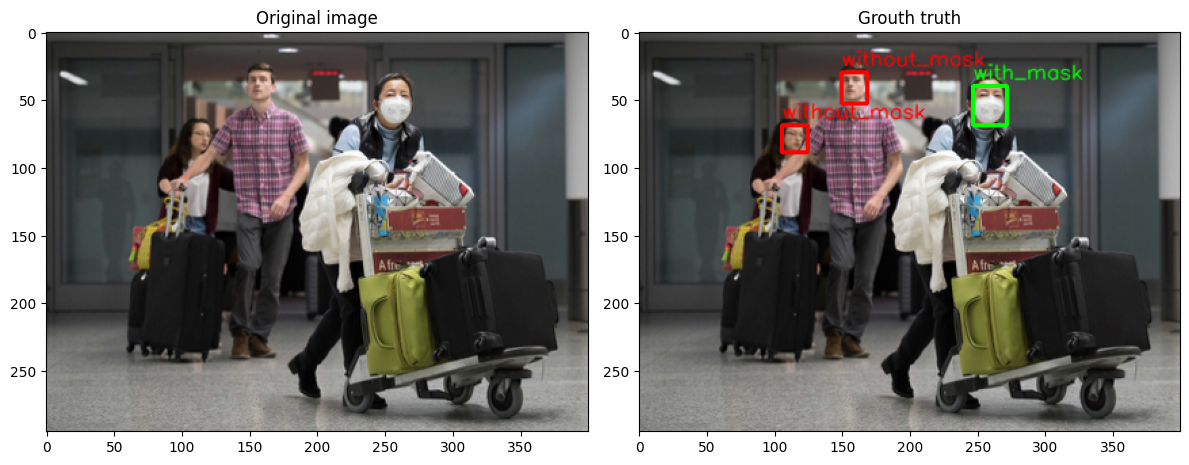

In [11]:
filename = 'maksssksksss129'
image_path = f'datasets/images/test/{filename}.png'
label_path = f'datasets/labels/test/{filename}.txt'
display_image(image_path, label_path=label_path)

# Model

In [12]:
!pip install ultralytics

In [13]:
!wandb disabled

'wandb' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
root = os.getcwd()
dataset_path = os.path.join(root, DATASET_DIR)

# Create dataset.yaml
yaml_text = f"""path: {dataset_path}
train: images/train 
val: images/val/ 
test: images/test/

names:
    0: without_mask
    1: with_mask
    2: mask_weared_incorrect"""

with open(f"data.yaml", 'w') as file:
    file.write(yaml_text)

In [15]:
from ultralytics import YOLO

In [24]:
# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model 
train_results = model.train(data="data.yaml", epochs=30, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.81 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.56  Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\Users\ADMIN\Code\face_mask_detection_yolo\datasets\labels\train.cache... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:00<?, ?it/s]
val: Scanning C:\Users\ADMIN\Code\face_mask_detection_yolo\datasets\labels\val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       2.6G      1.779      2.869      1.413         26        640: 100%|██████████| 38/38 [00:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        128        515     0.0126      0.548      0.288      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.64G      1.385      1.519      1.088         31        640: 100%|██████████| 38/38 [00:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        128        515      0.476      0.332      0.397      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.75G      1.311      1.264      1.058         72        640: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        128        515      0.571      0.405      0.471      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.19G      1.283      1.175      1.049         37        640: 100%|██████████| 38/38 [00:10<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        128        515      0.651      0.558      0.522      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.69G      1.213      1.072      1.038         23        640: 100%|██████████| 38/38 [00:10<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        128        515      0.587      0.582      0.567      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.72G      1.214      1.013      1.029         44        640: 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        128        515      0.653      0.505      0.584      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.51G      1.191     0.9365      1.017         45        640: 100%|██████████| 38/38 [00:10<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        128        515      0.667       0.58       0.59      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.35G        1.2     0.9148      1.017         42        640: 100%|██████████| 38/38 [00:10<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        128        515      0.653       0.65      0.711      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.51G      1.151     0.8437      1.006         31        640: 100%|██████████| 38/38 [00:10<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        128        515      0.673       0.65      0.657       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.56G      1.161     0.8335      1.005         22        640: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        128        515      0.713      0.696      0.711      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.84G       1.11     0.7813     0.9854         74        640: 100%|██████████| 38/38 [00:10<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        515      0.834      0.656      0.739      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.84G      1.107     0.7664     0.9958         55        640: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        128        515      0.682      0.677      0.694      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.02G      1.125     0.7592     0.9861         28        640: 100%|██████████| 38/38 [00:10<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        515      0.807      0.703      0.745      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.56G      1.093     0.7484     0.9828         67        640: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        128        515      0.735      0.662      0.701      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.82G      1.096     0.7375     0.9794         19        640: 100%|██████████| 38/38 [00:10<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        515      0.809      0.767      0.762      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.61G      1.089     0.7078     0.9847         41        640: 100%|██████████| 38/38 [00:10<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        128        515      0.885      0.722       0.77      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       2.7G      1.078     0.6988     0.9738         65        640: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        128        515      0.823       0.75      0.791      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.41G      1.063      0.682     0.9742         32        640: 100%|██████████| 38/38 [00:10<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        128        515      0.896      0.692      0.795      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.81G      1.051     0.6731      0.967        101        640: 100%|██████████| 38/38 [00:10<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        128        515      0.776      0.753      0.782      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.69G      1.037     0.6389     0.9551         39        640: 100%|██████████| 38/38 [00:10<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        128        515      0.903      0.759      0.808      0.535


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.77G      1.044     0.6742     0.9656          7        640: 100%|██████████| 38/38 [00:10<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        128        515      0.829      0.711      0.762      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.57G      1.031     0.6314     0.9611         11        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        128        515       0.88      0.727      0.805      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.78G      1.028     0.6214     0.9564         15        640: 100%|██████████| 38/38 [00:10<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        128        515      0.892      0.749      0.793      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.73G      1.008      0.591     0.9431         22        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        128        515      0.885       0.72      0.777      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       2.9G      0.977     0.5759     0.9372         21        640: 100%|██████████| 38/38 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        128        515      0.917      0.717      0.778      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       2.7G     0.9805      0.564     0.9376         22        640: 100%|██████████| 38/38 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        128        515      0.901      0.732      0.798      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.53G     0.9787     0.5639       0.93         28        640: 100%|██████████| 38/38 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        128        515      0.864      0.754      0.809      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.69G     0.9671     0.5509     0.9312         29        640: 100%|██████████| 38/38 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        128        515      0.861      0.766      0.815      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.88G     0.9534     0.5394     0.9243         16        640: 100%|██████████| 38/38 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        128        515      0.906      0.738      0.815      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.86G     0.9404     0.5195     0.9185         32        640: 100%|██████████| 38/38 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        128        515      0.879      0.767       0.82       0.57



30 epochs completed in 0.118 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.56  Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all        128        515      0.906      0.738      0.815      0.576
          without_mask         33         54      0.842      0.689      0.837      0.552
             with_mask        118        449      0.952      0.942      0.978      0.713
 mask_weared_incorrect         11         12      0.924      0.583       0.63      0.463
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train2


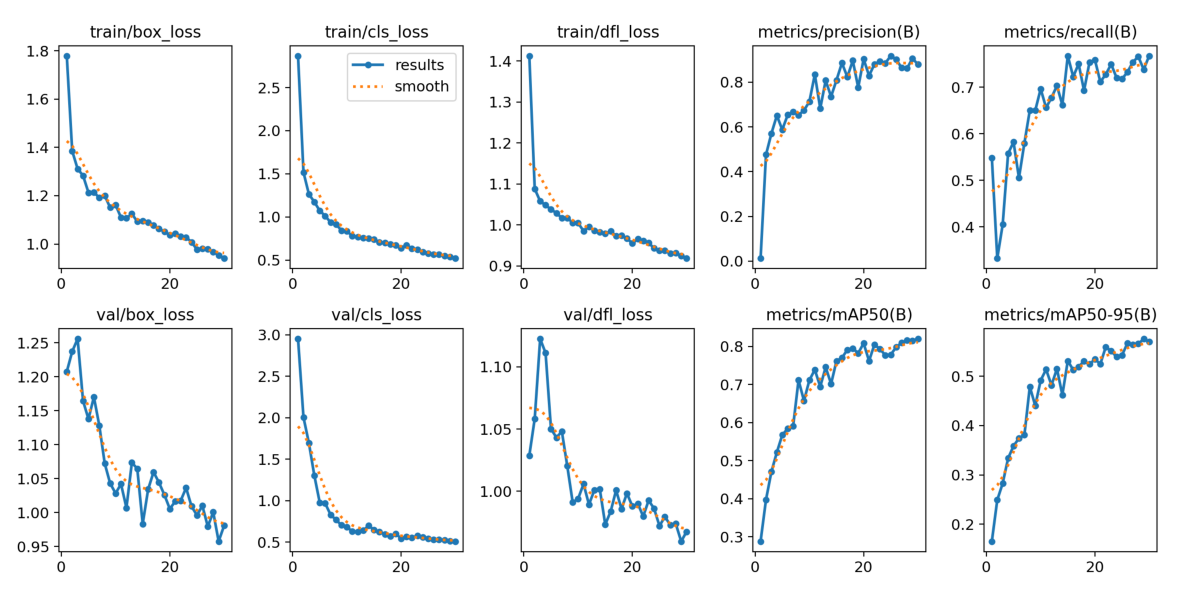

In [25]:
result = cv2.imread(f'{str(train_results.save_dir)}\\results.png')
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(result)
plt.show()

In [26]:
# Load a model
model = YOLO(f'{str(train_results.save_dir)}/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(data="data.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.56  Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ADMIN\Code\face_mask_detection_yolo\datasets\labels\val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


                   all        128        515      0.909      0.739      0.814       0.58
          without_mask         33         54      0.842      0.691      0.834      0.555
             with_mask        118        449      0.949      0.942      0.979      0.714
 mask_weared_incorrect         11         12      0.937      0.583      0.628       0.47
Speed: 1.2ms preprocess, 7.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\val3


In [27]:
metrics = model.val(data="data.yaml", split='test')  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.2.56  Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)


val: Scanning C:\Users\ADMIN\Code\face_mask_detection_yolo\datasets\labels\test.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


                   all        128        523      0.831      0.642      0.761      0.536
          without_mask         37         68      0.939      0.673      0.823      0.543
             with_mask        119        438       0.93        0.9       0.95      0.691
 mask_weared_incorrect         14         17      0.625      0.353       0.51      0.374
Speed: 1.0ms preprocess, 8.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val4


image 1/1 c:\Users\ADMIN\Code\face_mask_detection_yolo\datasets\images\test\maksssksksss129.png: 480x640 2 without_masks, 1 with_mask, 327.1ms
Speed: 12.0ms preprocess, 327.1ms inference, 22.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict2


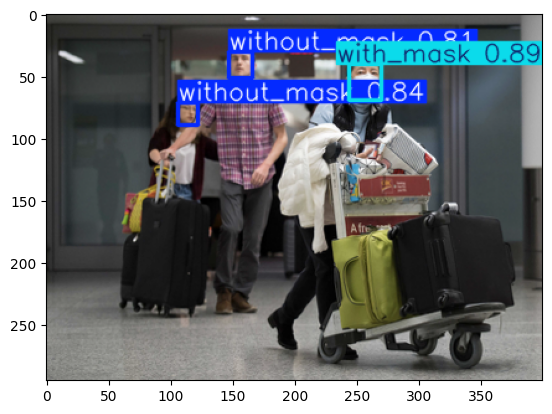

In [28]:
%matplotlib inline 

pred = model.predict(image_path, save=True)

# Display saved prediction
predicted_image_path = f'{pred[0].save_dir}/{filename}.png'
predicted_image = cv2.imread(predicted_image_path)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image)

In [29]:
def get_prediction(model, image_path):
    """Return a prediction of parsing model for parsing image
        Args:
            model (torch.nn.Module): Model used for prediction
            image_path (Path): Path to the image to be predicted 
        Return:
            prediction (list): Prediction for parsing image
    """
    results = model.predict(source=image_path, conf=0.7, verbose=False)
    prediction = []
    for i in range(len(results[0].boxes.xywhn)):
        pred = list(results[0].boxes.xywhn[i].cpu().numpy())
        class_index = results[0].boxes.cls[i].cpu().item()
        pred.append(class_index)
        conf = round(results[0].boxes.conf[i].cpu().item(), 2)
        pred.append(conf)
        prediction.append(pred)
    return prediction

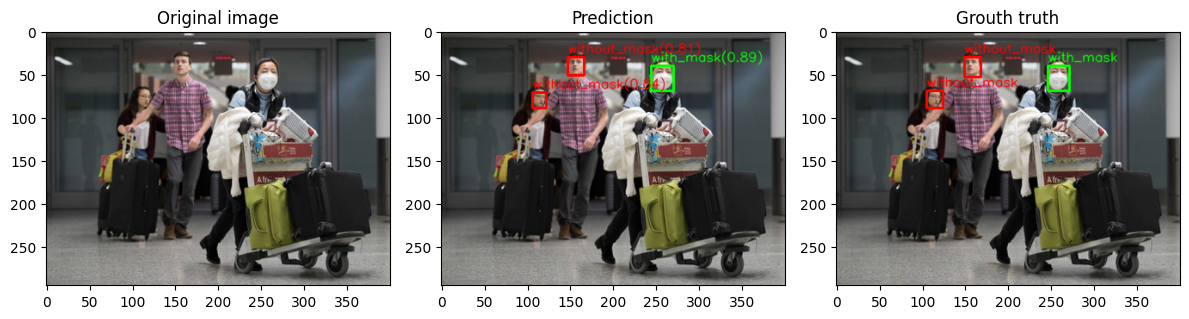

In [30]:
# Working with Results
prediction = get_prediction(model, image_path)
display_image(image_path, predicted_bndboxes=prediction, label_path=label_path)

# REAL-TIME CAMERA

In [ ]:
%matplotlib inline

os.makedirs('camera', exist_ok=True) # Directory to store images
print("Press 'q' to capture image")
print("Press 'w' to predict on real-time")
print("Press 'space' to close camera")

# Open the video capture object for your webcam (index 0)
cap = cv2.VideoCapture(0)

detect_in_real_time = False
while True:
  # Capture frame-by-frame
  ret, frame = cap.read()

  # Check if frame is captured successfully
  if not ret:
      print("Error! Unable to capture frame")
      break

  # Get keyboard input
  key = cv2.waitKey(1)
  
  # Press 'w' to detect in real time
  if key & 0xFF == ord('w'):
      detect_in_real_time = not detect_in_real_time
  
  if detect_in_real_time:
      realtime_image_path = 'camera/realtime.png'
      cv2.imwrite(realtime_image_path, frame)
      prediction = get_prediction(model, realtime_image_path)
      predicted_image = draw_bounding_boxes(frame, bndboxes=prediction, with_confidence_score=True, is_rgb=False)
      frame = predicted_image
    
  # Press 'q' to capture image and exit
  if key & 0xFF == ord('q'):
      # Save the frame as an image
      captured_image_path = 'camera/captured_image.png'
      cv2.imwrite(captured_image_path, frame)
      print("Image captured!")
      prediction = get_prediction(model, captured_image_path)
      display_image(captured_image_path, predicted_bndboxes=prediction)
      break

  # Press 'space' to exit without capturing
  if key & 0xFF == ord(' '):
      break
  
  # Display the resulting frame
  cv2.imshow('Camera', frame)

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()
